In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0      ddd762a3-76c4-4fb4-acdf-ee06e2c5bd6c
1      051cb4e7-19f5-47fa-b129-ffedca16c1ed
2      3b962738-4396-4872-a03d-96f93689967c
3      16dd257d-3d50-4f2e-af26-5f3c14c90cff
4      d8609335-8481-4eaa-b04d-3e727ba95240
                       ...                 
163    ffecdaf8-cf6c-4283-8fd5-a59b831c92d5
164    b1bd2ff1-d14d-45c7-b113-19be2069bcbf
165    ab00226f-f300-48dc-8e7e-2ea2e6fa4386
166    272aabaa-35e4-4f0f-b10c-b40f00e24af3
167    c40ea4db-e2bc-4dd6-81f4-e494849cb68a
Length: 168, dtype: object

In [4]:
targets = eids[pd.Series(df_base["eid"].unique()).str.startswith("5e96")]
targets

157    5e9685d2-9272-4923-9bb2-5a0a2d07692f
dtype: object

In [5]:
target_index = targets.index[0]

In [6]:
target_eid = df_base["eid"].unique()[target_index]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['5e9685d2-9272-4923-9bb2-5a0a2d07692f'], dtype=object)

In [7]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)

In [8]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [9]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [10]:
df

,index,p,eid,ts,loc,r,a,v,av,f,...,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,o.ct_dist,o.t_dist,speed,o.t_speed,f_mag
0,20625,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,0.116667,"[6910.143049340705, -575.8000084536842]",30,2.560768,"[-49.81687609588476, 32.37801193858648]",-0.298462,"[10432.825833376975, 10777.57603222645]",...,31797.530666,888.251664,1001.444800,-83.601019,54.871392,NaN,43277.160090,59.414281,1338.612232,15000.0
1,20626,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,0.283333,"[6901.905441819516, -570.3363132803851]",30,2.473524,"[-48.947473943103354, 33.276143274605346]",-0.798462,"[10432.825833376975, 10777.57603222645]",...,31797.530666,888.251664,1001.444800,-78.501948,61.947107,NaN,43278.540956,59.187473,1338.612232,15000.0
2,20627,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,0.450000,"[6893.8127346571255, -564.7229295510828]",30,2.302947,"[-48.07807179032195, 34.17427461062421]",-1.298462,"[10432.825833376975, 10777.57603222645]",...,31797.530666,888.251664,1001.444800,-66.847067,74.373851,NaN,43279.715895,58.986287,1338.612232,15000.0
3,20628,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,0.616667,"[6885.86492785353, -558.9598572657774]",30,2.049037,"[-47.208669637540545, 35.07240594664307]",-1.798462,"[10432.825833376975, 10777.57603222645]",...,31797.530666,888.251664,1001.444800,-46.021761,88.780614,NaN,43280.684900,58.810987,1338.612232,15000.0
4,20629,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,0.783333,"[6878.062021408731, -553.0470964244688]",30,1.712815,"[-46.33926748475914, 35.97053728266194]",-2.146024,"[10432.825833376975, 10777.576032226452]",...,31797.530666,888.251664,1001.444800,-14.154210,98.993224,NaN,43281.447966,58.661804,1338.612232,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,21758,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,189.069308,"[3657.28378989506, -39948.192623426185]",30,-5.032809,"[-207.65046141145706, -562.6749507484685]",0.000000,"[62798.043426967175, 189885.2436124112]",...,-84346.145541,-46.330446,-89.845108,31.496479,94.910336,464.253316,49953.434210,599.768134,101.087356,200000.0
1134,21759,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,189.235975,"[3623.0663182648073, -40040.78448895957]",30,-5.026951,"[-202.45569055674665, -546.8385599860092]",0.000000,"[61644.235158487434, 190262.94508317983]",...,-84346.145541,-45.853523,-88.867623,30.939972,95.093208,399.613283,49855.458650,583.112954,100.000000,200000.0
1135,21760,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,189.402642,"[3589.7056678484937, -40130.734041781245]",30,-5.016096,"[-197.39779493229872, -530.9580012235066]",0.000000,"[59248.90616570194, 191022.42569438764]",...,-84346.145541,-45.874235,-88.856933,29.905939,95.423450,308.468704,49760.226939,566.464728,100.000000,200000.0
1136,21761,SHP,5e9685d2-9272-4923-9bb2-5a0a2d07692f,189.569308,"[3557.1707517792424, -40218.03144447823]",30,-4.996519,"[-192.5953381213036, -514.9985418357101]",0.140041,"[55071.594807701804, 192268.3526879458]",...,-84346.145541,-45.894159,-88.846644,28.032223,95.990596,223.835276,49667.733249,549.833122,100.000000,200000.0


In [11]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'ct': '0b273a4f-267c-4ef9-ba7f-a4b9f4d3477a',
 'ct_loc': [3591.1408103974227, -40439.40838363355],
 'ct_v': [0.0, 0.0],
 'ct_ts': 181.41930833336986,
 'ct_dv': [-1300.6824863733493, 2703.3729061381155],
 'ct_tc': 0.0,
 'ct_ct': 1,
 'ct_cloc': [3591.1631460708873, -40439.332752101065],
 'ct_cradius': 527.2578360402177,
 'ct_cn': [[3591.1408103974227, -40439.40838363355]],
 'cac': True,
 'cbdr': False,
 'cbdr_hist': [[-28.551246358105345, -389.50991867420817],
  [-25.18554654815398, -380.4223680834839],
  [-21.82838849140944, -371.3612493559194],
  [-18.479738065660058, -362.3265734941815],
  [-15.139573432829366, -353.3183475144251],
  [-11.807856967326188, -344.3365834583965],
  [-8.484564676922673, -335.38128897380375],
  [-5.169654927999545, -326.4524772748773],
  [-1.863101265492332, -317.55015672084846],
  [1.435142548928979, -308.67434185230377],
  [4.725105797800552, -299.82504183191486],
  [8.006840031926913, -291.0022727039832]

# Basic Ship Vitals

## Position and Heading

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=189.73597500004314, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

In [13]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,1138.000000,1138.000000
mean,26547.340083,17047.783508
std,10588.512700,19703.862364
min,3525.405332,-40302.659970
25%,18177.644974,7378.892095
50%,32261.814493,27218.091294
75%,35352.617470,31492.875746
max,35352.617470,31492.875746


Text(0.5, 1.0, 'position')

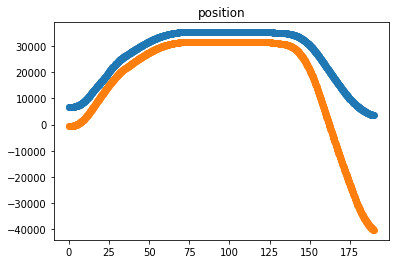

In [14]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

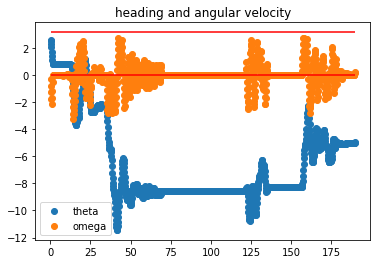

In [15]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

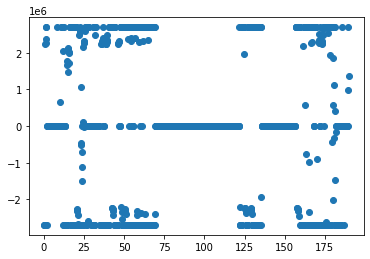

In [16]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

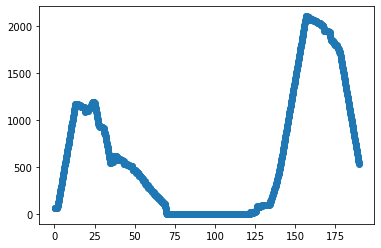

In [17]:
plt.scatter(df["ts"], df["speed"])

In [18]:
def plot_velocity(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["v.x"], label="x")
    plt.scatter(sample["ts"], sample["v.y"], label="y")
    plt.legend()
    plt.title("velocity")
    
ipywidgets.interact(plot_velocity, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_velocity(hist_length, max_time)>

In [19]:
def plot_acceleration(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (sample["v.x"].shift(1) - sample["v.x"]) / (sample["ts"].shift(1) - sample["ts"]), label="x")
    plt.scatter(sample["ts"], (sample["v.y"].shift(1) - sample["v.y"]) / (sample["ts"].shift(1) - sample["ts"]), label="y")
    plt.yscale("symlog")
    plt.legend()
    plt.title("acceleration")
    
ipywidgets.interact(plot_acceleration, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_acceleration(hist_length, max_time)>

In [20]:
def plot_force(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["f_mag"])
    plt.yscale("log")
    plt.title("force")

ipywidgets.interact(plot_force, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_force(hist_length, max_time)>

# Behavior Monitoring

In [21]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[14.235975000000288, None, 130.4026416666626, 19.735975000000163]

In [56]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cbdr"]
    first_ts = [
        next(
            (sample.loc[idx]["ts"] if idx is not None else None
             for idx, v in zip(sample.index, (~sample[c].isna() & sample[c] == True))
             if v),
            None
        )
        for c in flag_cols
    ]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [23]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                              o.t_dist  \
                            count         min         max           min   
o.t_loc.x     o.t_loc.y                                                   
-19237.417914 -84346.145541   410  121.569308  189.735975  49577.966309   
 35630.868084  31797.530666   418    0.116667   69.735975    413.043512   

                                            
                                       max  
o.t_loc.x     o.t_loc.y                     
-19237.417914 -84346.145541  128057.607411  
 35630.868084  31797.530666   43282.415779

In [24]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o.t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o.t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_target_distance(hist_length, max_time)>

In [25]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

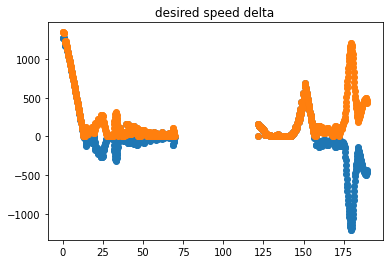

In [26]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

### Collision Threats

In [27]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.show_collision_threats(hist_length, max_time)>

In [28]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"]*2, color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"], color="orange", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"], color="red", marker="_")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(sample["o.ct_dist"].min())

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_distance(hist_length, max_time)>

Text(0.5, 1.0, 'Collision Threat and Time Since Detection')

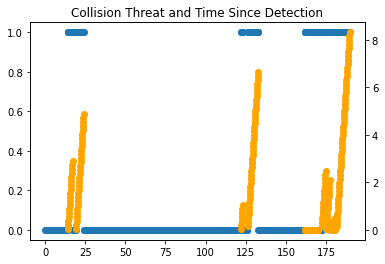

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")
plt.title("Collision Threat and Time Since Detection")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [30]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

In [31]:
def plot_collision_threat_loc(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_cloc.x"])
    ax2.scatter(sample["ts"], sample["o.ct_cloc.y"], color="orange")
    plt.title("collision threat coalesced location")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_loc,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_threat_loc(hist_length, max_time)>

In [60]:
def plot_collision_threat_radius(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("collision threat radius")
    plt.legend()
    plt.show()

ipywidgets.interact(
    plot_collision_threat_radius,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_threat_radius(hist_length, max_time)>

## Nearest Neighbors

In [33]:
neighborhood_radius = 5e4
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nd"]*np.pi*neighborhood_radius**2)
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [34]:
def plot_nearest_neighbor(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nnd"])
    plt.title("nearest neighor dist")
    plt.show()

ipywidgets.interact(
    plot_nearest_neighbor,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_nearest_neighbor(hist_length, max_time)>

In [35]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_dv(hist_length, max_time)>

In [63]:
# 
# Smallest enclosing circle - Library (Python)
# 
# Copyright (c) 2020 Project Nayuki
# https://www.nayuki.io/page/smallest-enclosing-circle
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public License
# along with this program (see COPYING.txt and COPYING.LESSER.txt).
# If not, see <http://www.gnu.org/licenses/>.
# 

import math, random


# Data conventions: A point is a pair of floats (x, y). A circle is a triple of floats (center x, center y, radius).

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
	# Convert to float and randomize order
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
	c = (p[0], p[1], 0.0)
	for (i, q) in enumerate(points):
		if not is_in_circle(c, q):
			if c[2] == 0.0:
				c = make_diameter(p, q)
			else:
				c = _make_circle_two_points(points[ : i + 1], p, q)
	return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

In [84]:
def plot_radius_comparison(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    foo = sample["o.ct_cn"].apply(lambda x: np.nan if isinstance(x, float) else make_circle(x)[2]+30)
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], foo, label="min radius")
    plt.legend()
    plt.title("cradius vs smallest enclosing radius")
    plt.show()

ipywidgets.interact(
    plot_radius_comparison,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_radius_comparison(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [39]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    if show_v:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"]+ctdv_df["v.x"], ctdv_df["o.ct_dv.y"]+ctdv_df["v.y"], label="ctdv", color="orange")
    if show_tv:
        plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o.ct_v.x"], sample["o.ct_v.y"], label="ctv", color="cyan")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample[~(sample["o.ct_cloc"].isna())]
    if len(cloc_df) > 0:
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        cmargin = cloc_df.iloc[-1].get(["o.scm"],500)
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+cmargin, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+cmargin*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(cradius)
        
        cn_x, cn_y = list(zip(*cloc_df.iloc[-1]["o.ct_cn"]))
        plt.scatter(cn_x, cn_y, label="ct_cnloc", marker="+", color="pink")
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc", marker="x")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (54140, -58169)
    #radius = 30000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=2, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_chart(hist_length=189.73597500004314, max_time=189.73597500004314, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True)>

## Position and Heading

In [37]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    #plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    #plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=189.6193…

<function __main__.plot_collision_chart(hist_length=189.73597500004314, max_time=189.73597500004314)>

In [38]:
for s in df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc":"min", "o.ad":"min"}).values:
    print(f'{s}')

[list([-19237.417913812063, -84346.14554050939]) 500.0]
[list([35630.86808388993, 31797.530665976527]) 500.0]


# 